# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

22:18:43 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=333110;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=997272;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=857065;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=618889;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB080916009,119.800,-56.600,54725.0088613,62.977


To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

22:19:41 INFO      Auto-determined polynomial order: 0                                ]8;id=172130;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=316722;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

22:19:58 INFO      None 0-order polynomial fit with the mle method                               ]8;id=957142;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=268247;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=612849;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=452088;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=352190;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=516799;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

22:19:59 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=414335;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=618530;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=964616;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=260400;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=440384;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=637632;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=279399;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=506086;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=149596;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=7525;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=425272;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=204274;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

22:20:02 INFO      Now using 120 bins                                                          ]8;id=64765;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=20529;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

22:20:04 INFO      Auto-determined polynomial order: 1                                ]8;id=284885;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=354236;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

22:20:22 INFO      None 1-order polynomial fit with the mle method                               ]8;id=107827;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=237554;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=393260;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=822588;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=52191;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=143417;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=493557;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=835793;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=629892;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=586341;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

22:20:23 INFO      Auto-probed noise models:                                                    ]8;id=668036;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=643083;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=654505;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=693091;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=907777;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=629359;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=367839;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=703136;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=27754;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=592950;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

22:20:25 INFO      Auto-determined polynomial order: 1                                ]8;id=455246;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=100786;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

22:20:42 INFO      None 1-order polynomial fit with the mle method                               ]8;id=264732;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=220211;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=436709;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=807383;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=759263;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=547924;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

22:20:43 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=413045;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=405428;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=692969;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=73502;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=765891;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=808780;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=189271;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=701089;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=593176;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=961917;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=969383;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=315020;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=84496;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=712455;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

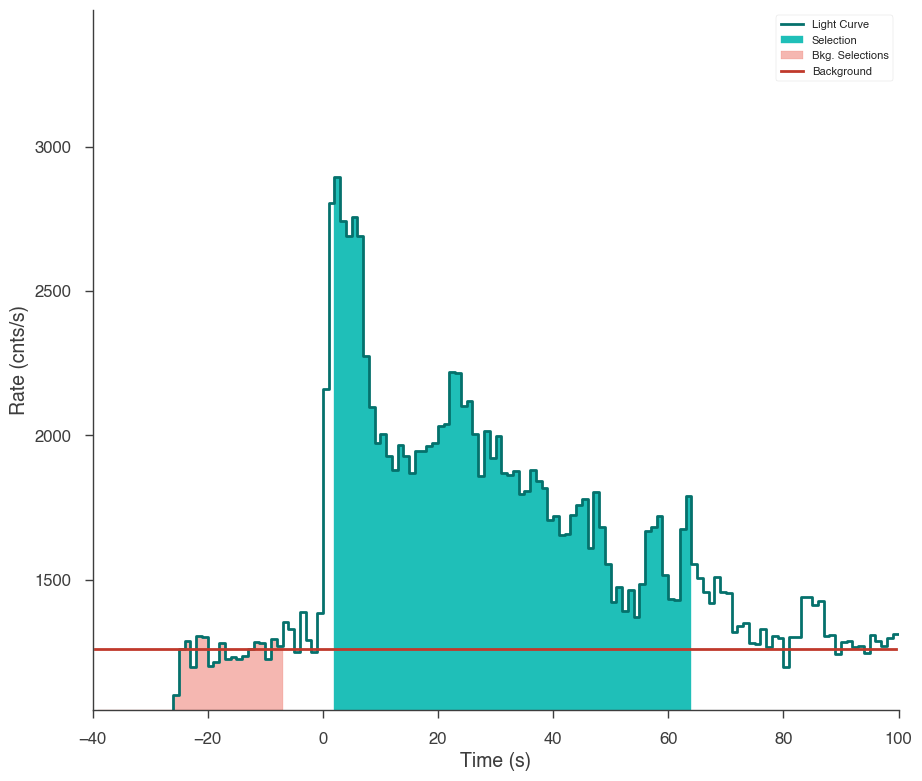

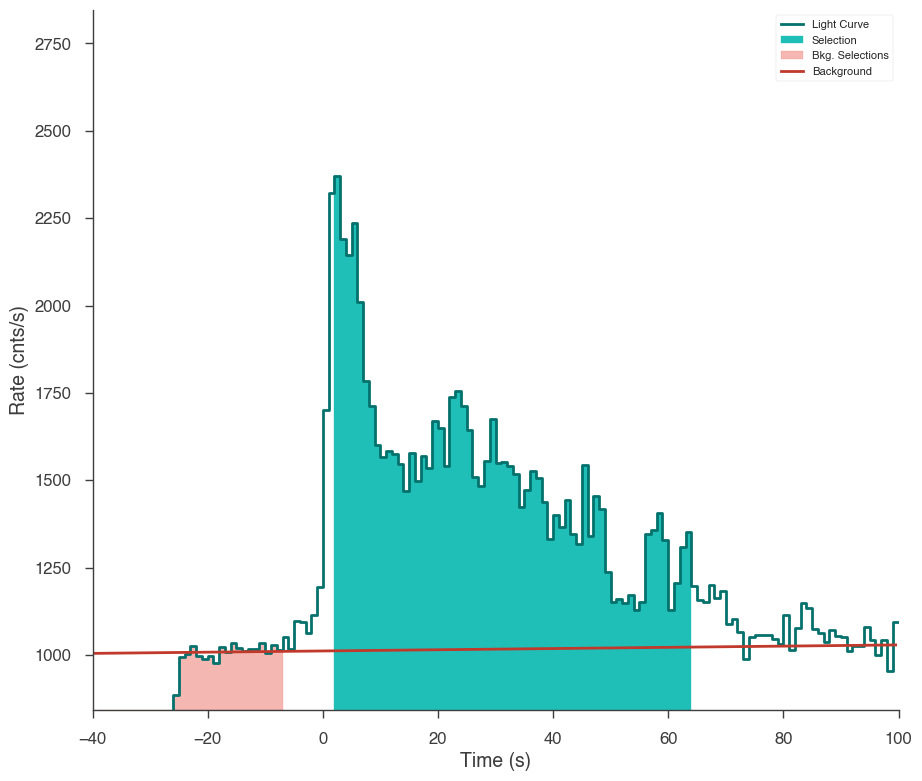

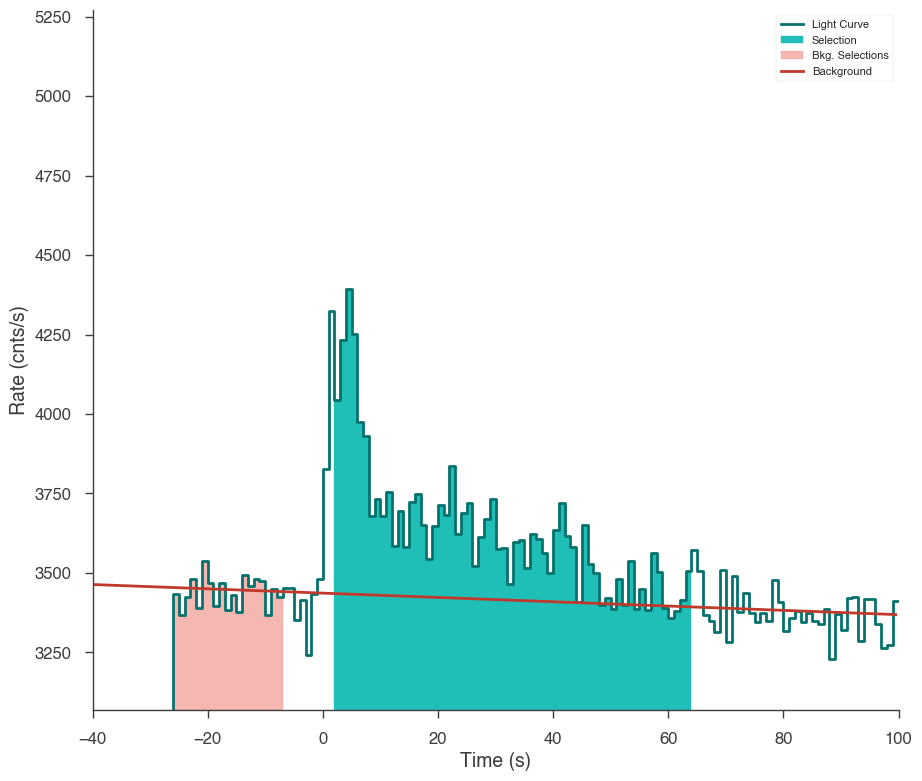

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

22:20:44 INFO      sampler set to multinest                                                ]8;id=419515;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=784701;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

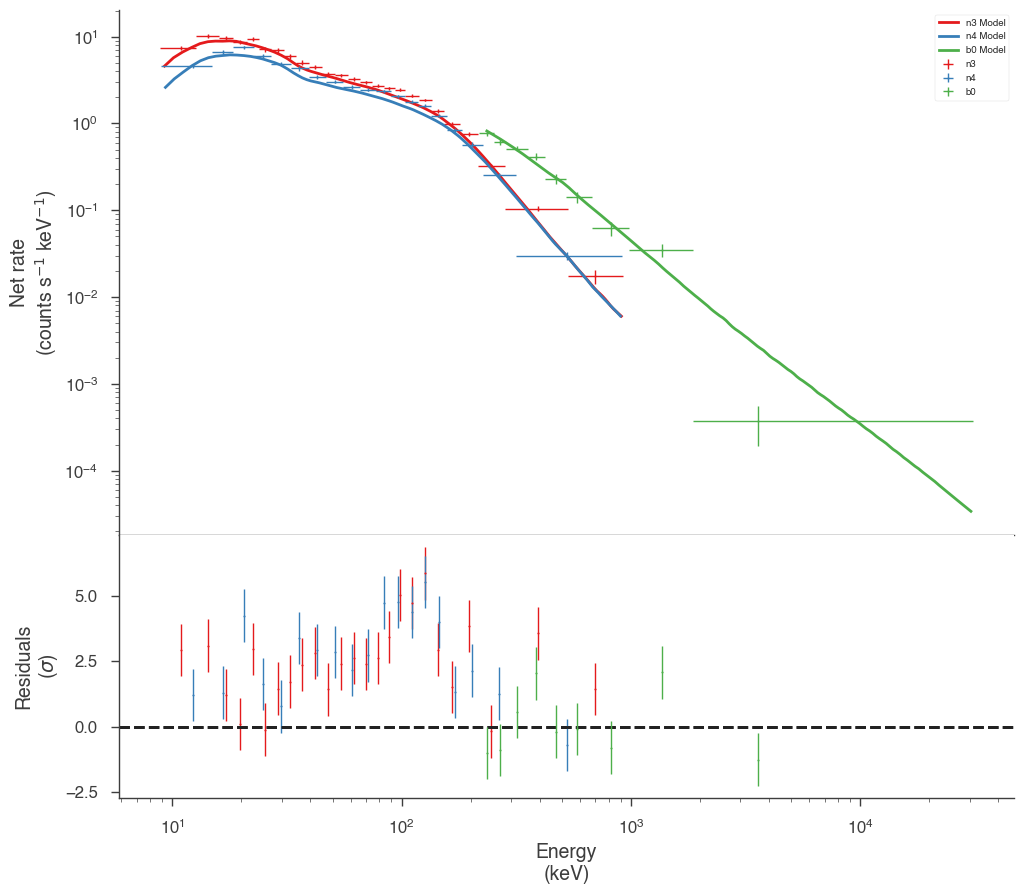

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -3101.1213435583059      +/-  0.22381071532829147     
 Total Likelihood Evaluations:        22852
 Sampling finished. Exiting MultiNest



22:21:07 INFO      fit restored to maximum of posterior                                         ]8;id=662544;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=900239;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=723237;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=123027;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
GRB080916009...K,(1.459 -0.009 +0.028) x 10^-2,1 / (cm2 keV s)
GRB080916009...alpha,-1.0944 +0.0009 +0.04,
GRB080916009...break_energy,(1.94 +0.07 +0.7) x 10^2,keV
GRB080916009...break_scale,(0.0 +1.7 +3.4) x 10^-1,
GRB080916009...beta,-1.978 -0.22 -0.029,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0,-1050.387767
n3,-1019.061782
n4,-1010.830449
total,-3080.279997


Values of statistical measures:

,statistical measures
AIC,6170.730449
BIC,6189.962660
DIC,6179.950303
PDIC,4.396229
log(Z),-1346.799887


Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=712375;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=597936;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

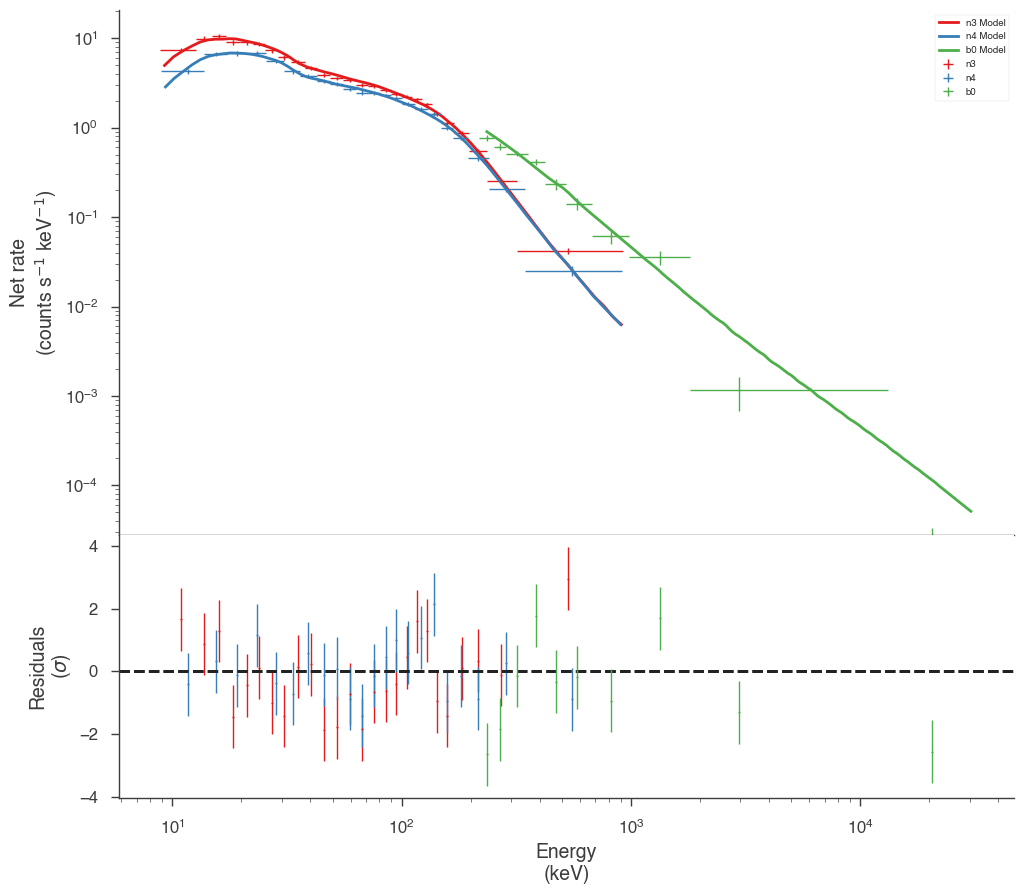

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

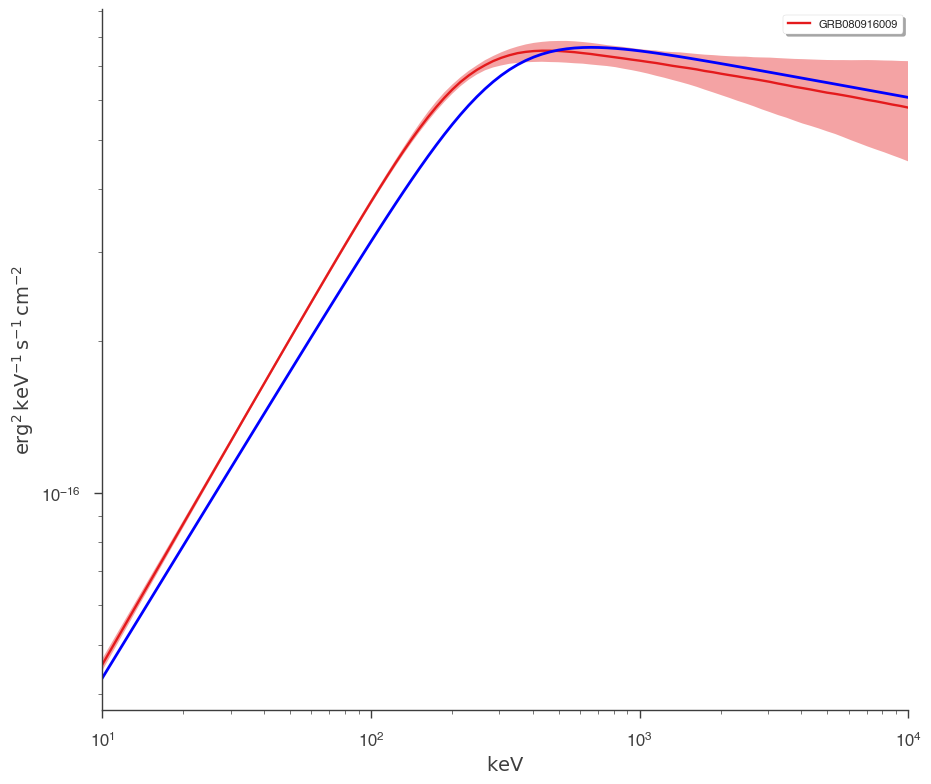

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

22:23:08 INFO      Created 15 bins via bayesblocks                                       ]8;id=595044;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=759496;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


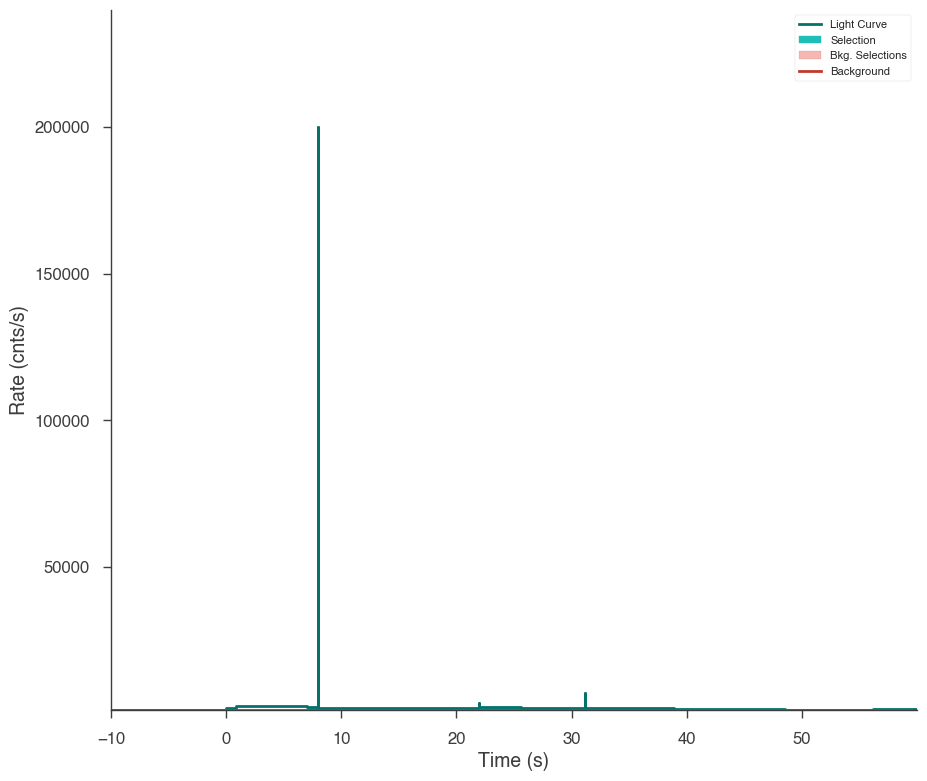

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

         INFO      Created 12 bins via custom                                            ]8;id=760785;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=459889;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

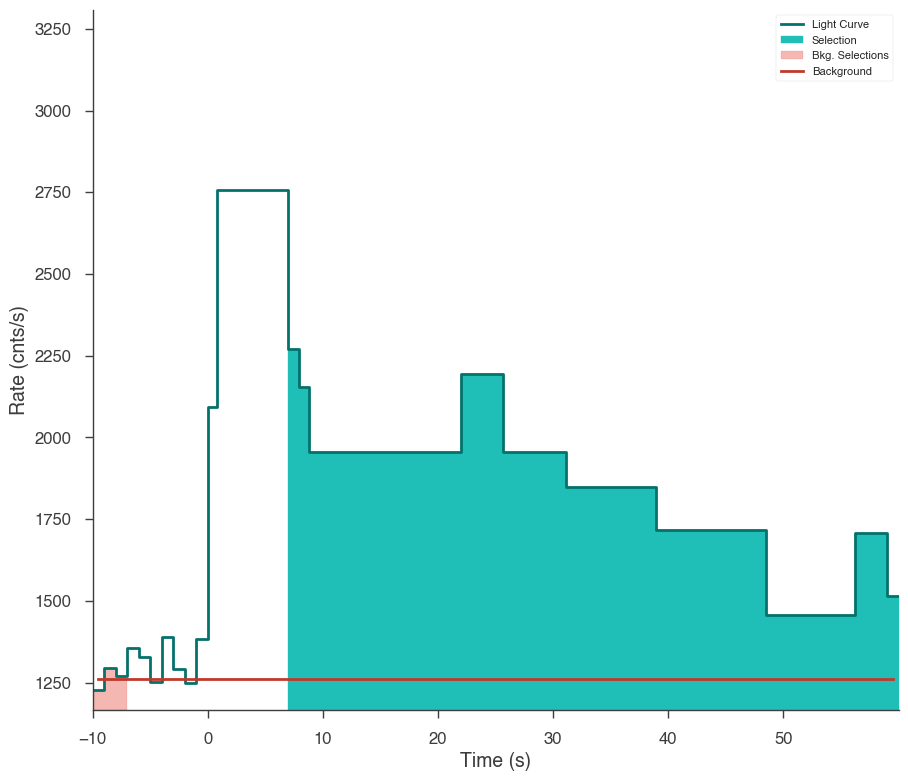

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

22:23:09 INFO      Created 12 bins via custom                                            ]8;id=819087;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=583544;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=375612;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=649356;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=39389;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=336122;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

22:23:10 INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=743172;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=336434;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=453825;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=786672;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

22:23:11 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=547507;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=327663;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=743552;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=336906;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=459114;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=184975;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=5162;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=90223;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=908154;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=233536;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=184342;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=47952;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 107 bins                                                          ]8;id=886480;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=655615;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=13574;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=723747;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -796.78031178815638      +/-  0.20012512273562649     
 Total Likelihood Evaluations:        18771
 Sampling finished. Exiting MultiNest



22:23:31 INFO      fit restored to maximum of posterior                                         ]8;id=675988;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=995747;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=579472;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=227879;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.04 -0.4 +0.07) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.2 -1.2 -0.4) x 10^-1,
grb.spectrum.main.Band.xp,(3.55 -0.35 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-1.762 -0.007 +0.026,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval0,-288.296754
n3_interval0,-251.328954
n4_interval0,-268.059088
total,-807.684796


Values of statistical measures:

,statistical measures
AIC,1623.482906
BIC,1638.891724
DIC,1577.493307
PDIC,1.807268
log(Z),-346.037293


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=101277;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=595398;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=652648;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=743860;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=785317;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=654731;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=510023;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=24596;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=623021;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=176057;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=307092;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=626194;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=915322;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=266689;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1943.8952905844890      +/-  0.21674349183995267     
 Total Likelihood Evaluations:        21518
 Sampling finished. Exiting MultiNest



22:23:53 INFO      fit restored to maximum of posterior                                         ]8;id=673655;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=379209;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=406113;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=474589;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(4.10 -0.14 +0.08) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.64 -0.29 +0.16) x 10^-1,
grb.spectrum.main.Band.xp,(6.30 -0.21 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.137 -0.17 -0.013,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval1,-673.709278
n3_interval1,-642.009464
n4_interval1,-645.567326
total,-1961.286068


Values of statistical measures:

,statistical measures
AIC,3930.685450
BIC,3946.094268
DIC,3872.526606
PDIC,2.882460
log(Z),-844.222998


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=564280;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=365070;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=723048;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=966968;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=306626;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=772672;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=514387;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=700075;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=199600;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=987292;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 115 bins                                                          ]8;id=803245;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=654248;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=529726;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=915921;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -908.17904158480542      +/-  0.19436991915541840     
 Total Likelihood Evaluations:        19755
 Sampling finished. Exiting MultiNest



22:24:13 INFO      fit restored to maximum of posterior                                         ]8;id=31747;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=828789;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=818874;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=580163;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.578 +0.023 +0.4) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.03 -0.04 +0.06,
grb.spectrum.main.Band.xp,(5.51 -1.9 -0.13) x 10^2,keV
grb.spectrum.main.Band.beta,-1.858 -0.016 +0.15,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval2,-324.278809
n3_interval2,-288.808821
n4_interval2,-312.274647
total,-925.362276


Values of statistical measures:

,statistical measures
AIC,1858.837867
BIC,1874.246685
DIC,1804.440269
PDIC,1.940838
log(Z),-394.417146


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=278442;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=167661;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=70638;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=689604;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=364029;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=163200;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=304526;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=508670;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=299910;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=278919;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 109 bins                                                          ]8;id=192863;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=966307;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=284758;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=508198;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.97750367291633      +/-  0.17790723558175631     
 Total Likelihood Evaluations:        17400
 Sampling finished. Exiting MultiNest



22:24:30 INFO      fit restored to maximum of posterior                                         ]8;id=872099;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=689911;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=507058;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=6559;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.93 -0.23 +0.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.2 -0.6 +1.3) x 10^-1,
grb.spectrum.main.Band.xp,(3.3 -0.7 +0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.18 -0.17 +0.22,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval3,-298.339830
n3_interval3,-242.406654
n4_interval3,-262.376650
total,-803.123134


Values of statistical measures:

,statistical measures
AIC,1614.359582
BIC,1629.768400
DIC,1569.752258
PDIC,2.573470
log(Z),-342.648576


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=348232;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=929057;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=118401;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=577400;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=191629;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=875703;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=463868;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=28946;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=530285;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=278774;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=802207;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=945771;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=384978;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=333509;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2271.2079412122180      +/-  0.20053205961344600     
 Total Likelihood Evaluations:        20983
 Sampling finished. Exiting MultiNest



22:24:50 INFO      fit restored to maximum of posterior                                         ]8;id=891845;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=110587;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=534975;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=710188;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.06 -0.08 +0.12) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.80 -0.28 +0.4) x 10^-1,
grb.spectrum.main.Band.xp,(3.9 -0.4 +0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-1.94 -0.18 +0.04,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval4,-778.467378
n3_interval4,-757.081894
n4_interval4,-746.668537
total,-2282.217809


Values of statistical measures:

,statistical measures
AIC,4572.548932
BIC,4587.957749
DIC,4527.120261
PDIC,2.913153
log(Z),-986.373076


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=404624;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=996990;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=427228;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=897637;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=953875;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=894048;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=332070;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=586442;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=925070;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=903632;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=301299;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=942407;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=67551;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=802002;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1573.3573160399676      +/-  0.19312169938904758     
 Total Likelihood Evaluations:        18757
 Sampling finished. Exiting MultiNest



22:25:08 INFO      fit restored to maximum of posterior                                         ]8;id=425105;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=656473;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=214314;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=847039;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.82 -0.19 +0.17) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.1 +/- 0.5) x 10^-1,
grb.spectrum.main.Band.xp,(4.1 -0.4 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.094 -0.32 +0.033,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval5,-536.697834
n3_interval5,-523.393947
n4_interval5,-527.741391
total,-1587.833172


Values of statistical measures:

,statistical measures
AIC,3183.779659
BIC,3199.188477
DIC,3136.363756
PDIC,3.112649
log(Z),-683.300400


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=248134;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=214369;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=878209;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=478012;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=488087;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=476238;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=713030;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=670850;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=611137;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=699725;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=520526;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=810773;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=24028;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=700336;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1755.4738698350077      +/-  0.19337275963416609     
 Total Likelihood Evaluations:        19220
 Sampling finished. Exiting MultiNest



22:25:26 INFO      fit restored to maximum of posterior                                         ]8;id=172221;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=435934;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=404802;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=294972;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.96 -0.11 +0.14) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.01 +/- 0.05,
grb.spectrum.main.Band.xp,(4.4 -0.6 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.34 -0.4 +0.17,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval6,-609.444651
n3_interval6,-584.302205
n4_interval6,-576.743451
total,-1770.490306


Values of statistical measures:

,statistical measures
AIC,3549.093926
BIC,3564.502744
DIC,3501.028045
PDIC,3.255310
log(Z),-762.392615


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=67337;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=33416;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=345940;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=84192;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=32240;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=345708;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=994774;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=79224;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=757802;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=133468;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=869309;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=415456;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=104472;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=862081;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1939.7974246753427      +/-  0.19234419932767249     
 Total Likelihood Evaluations:        19227
 Sampling finished. Exiting MultiNest



22:25:45 INFO      fit restored to maximum of posterior                                         ]8;id=840867;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=941335;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=885167;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=950401;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.67 -0.06 +0.13) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.042 -0.018 +0.06,
grb.spectrum.main.Band.xp,(4.3 -0.6 +0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.23 -0.34 +0.16,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval7,-662.291386
n3_interval7,-640.865932
n4_interval7,-650.306165
total,-1953.463483


Values of statistical measures:

,statistical measures
AIC,3915.040281
BIC,3930.449099
DIC,3868.805141
PDIC,3.359634
log(Z),-842.443318


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=25975;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=668362;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=28774;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=261461;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=426531;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=831463;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=217573;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=558708;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=515462;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=76156;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=257011;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=928513;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=933856;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=738300;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2053.7128857292469      +/-  0.18632312347816293     
 Total Likelihood Evaluations:        19798
 Sampling finished. Exiting MultiNest



22:26:03 INFO      fit restored to maximum of posterior                                         ]8;id=567791;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=760527;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=101478;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=420278;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.54 -0.14 +0.11) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.4 -0.8 +0.5) x 10^-1,
grb.spectrum.main.Band.xp,(3.7 -0.4 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.26 -0.5 +0.08,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval8,-702.386073
n3_interval8,-698.392093
n4_interval8,-665.943328
total,-2066.721495


Values of statistical measures:

,statistical measures
AIC,4141.556304
BIC,4156.965122
DIC,4098.635767
PDIC,3.472682
log(Z),-891.916174


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=314819;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=181684;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=308661;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=507786;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=746164;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=683467;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=787009;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=630651;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=866072;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=476444;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=336136;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=83681;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=755342;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=870812;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1878.5948416636861      +/-  0.14437388157040193     
 Total Likelihood Evaluations:        12940
 Sampling finished. Exiting MultiNest



22:26:15 INFO      fit restored to maximum of posterior                                         ]8;id=579328;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=947568;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=187144;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=898334;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.1 -0.4 +1.3) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.4 -2.0 +3.3) x 10^-1,
grb.spectrum.main.Band.xp,(1.1 -0.4 +0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-1.88 -0.35 +0.14,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval9,-648.373410
n3_interval9,-617.016873
n4_interval9,-616.336215
total,-1881.726498


Values of statistical measures:

,statistical measures
AIC,3771.566311
BIC,3786.975128
DIC,3694.128380
PDIC,-53.108068
log(Z),-815.863373


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=381239;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=372614;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=70242;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=908587;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=653988;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=934408;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=272369;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=119235;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=693133;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=810130;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=117367;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=373091;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=221548;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=667102;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1322.2204204563425      +/-  0.16880635104725478     
 Total Likelihood Evaluations:        15109
 Sampling finished. Exiting MultiNest



22:26:29 INFO      fit restored to maximum of posterior                                         ]8;id=773994;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=812514;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=998612;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=141695;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.11 -0.5 +0.24) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.2 -1.5 +0.9) x 10^-1,
grb.spectrum.main.Band.xp,(2.15 -0.20 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-1.99 -0.4 +0.07,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval10,-460.686119
n3_interval10,-437.932148
n4_interval10,-433.091711
total,-1331.709978


Values of statistical measures:

,statistical measures
AIC,2671.533270
BIC,2686.942088
DIC,2635.958534
PDIC,2.246002
log(Z),-574.233032


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=340630;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=229525;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=836050;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=771058;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=110575;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=594410;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=809351;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=607237;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=416089;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=552988;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=138449;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=976242;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=687948;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=66432;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -811.89387554483562      +/-  0.14649579199643750     
 Total Likelihood Evaluations:        12531
 Sampling finished. Exiting MultiNest



22:26:41 INFO      fit restored to maximum of posterior                                         ]8;id=757496;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=856556;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=175322;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=778672;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.1 -1.1 +1.6) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-4.4 +/- 2.5) x 10^-1,
grb.spectrum.main.Band.xp,(1.22 -0.20 +0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.11 -0.5 +0.16,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval11,-292.379473
n3_interval11,-272.447200
n4_interval11,-255.793680
total,-820.620352


Values of statistical measures:

,statistical measures
AIC,1649.354019
BIC,1664.762836
DIC,1618.008745
PDIC,0.705991
log(Z),-352.601030


### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=277514;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=826345;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:26:42 INFO      fit restored to median of posterior                                          ]8;id=967376;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=260481;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:26:43 INFO      fit restored to median of posterior                                          ]8;id=364848;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=458420;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:26:44 INFO      fit restored to median of posterior                                          ]8;id=540514;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=9075;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:26:45 INFO      fit restored to median of posterior                                          ]8;id=86096;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=428452;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:26:46 INFO      fit restored to median of posterior                                          ]8;id=615215;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=103629;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:26:47 INFO      fit restored to median of posterior                                          ]8;id=802618;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=410223;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=364689;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=750293;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:26:48 INFO      fit restored to median of posterior                                          ]8;id=628542;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=713851;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:26:49 INFO      fit restored to median of posterior                                          ]8;id=893055;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=51873;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:26:50 INFO      fit restored to median of posterior                                          ]8;id=867798;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=53393;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

22:26:51 INFO      fit restored to median of posterior                                          ]8;id=883969;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=895328;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

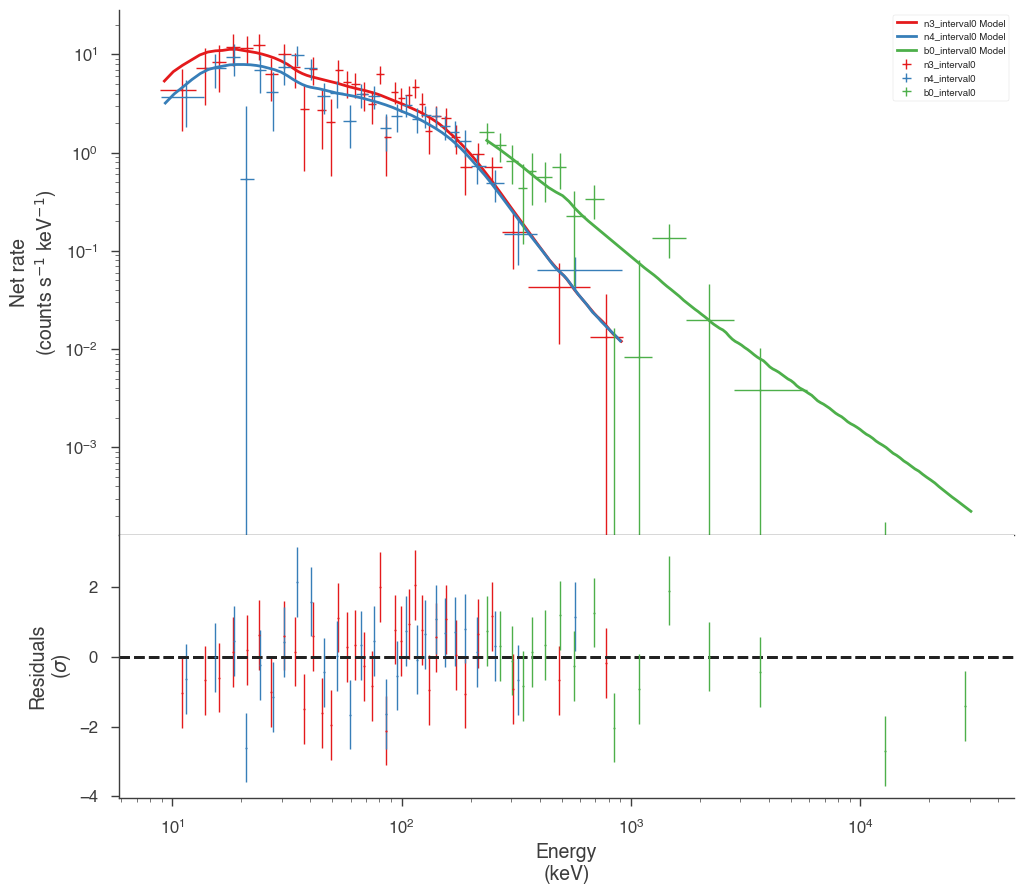

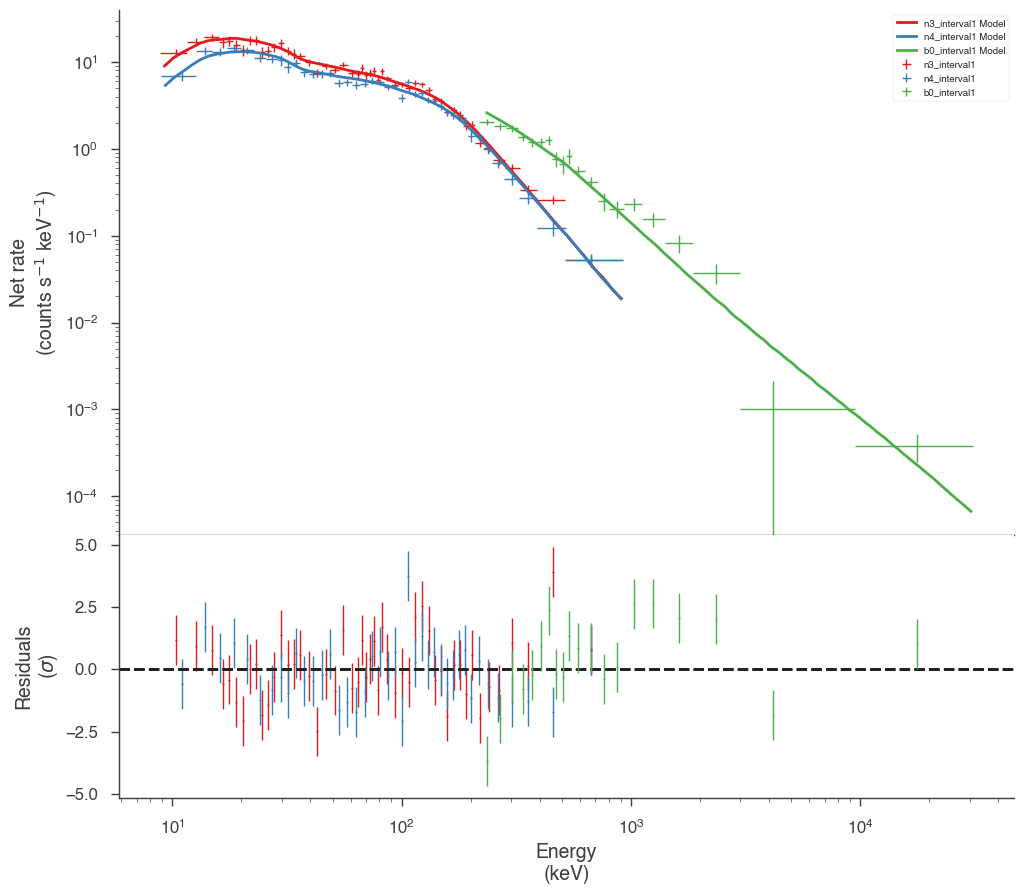

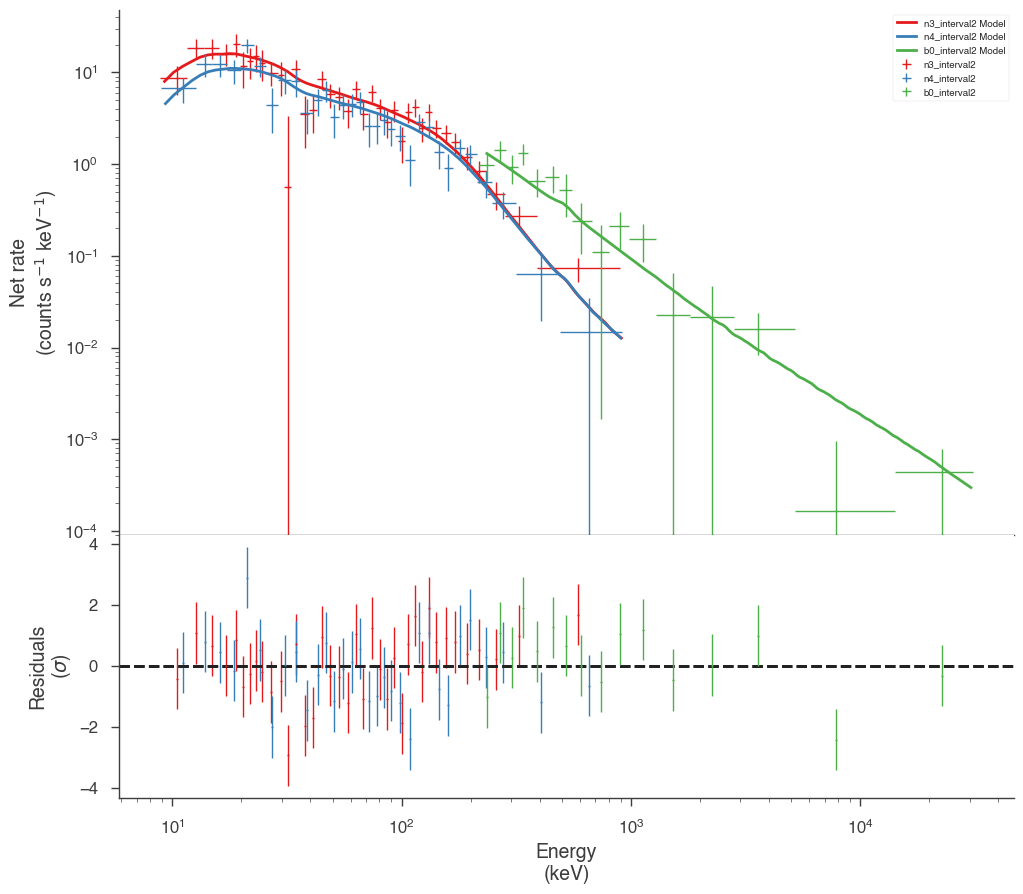

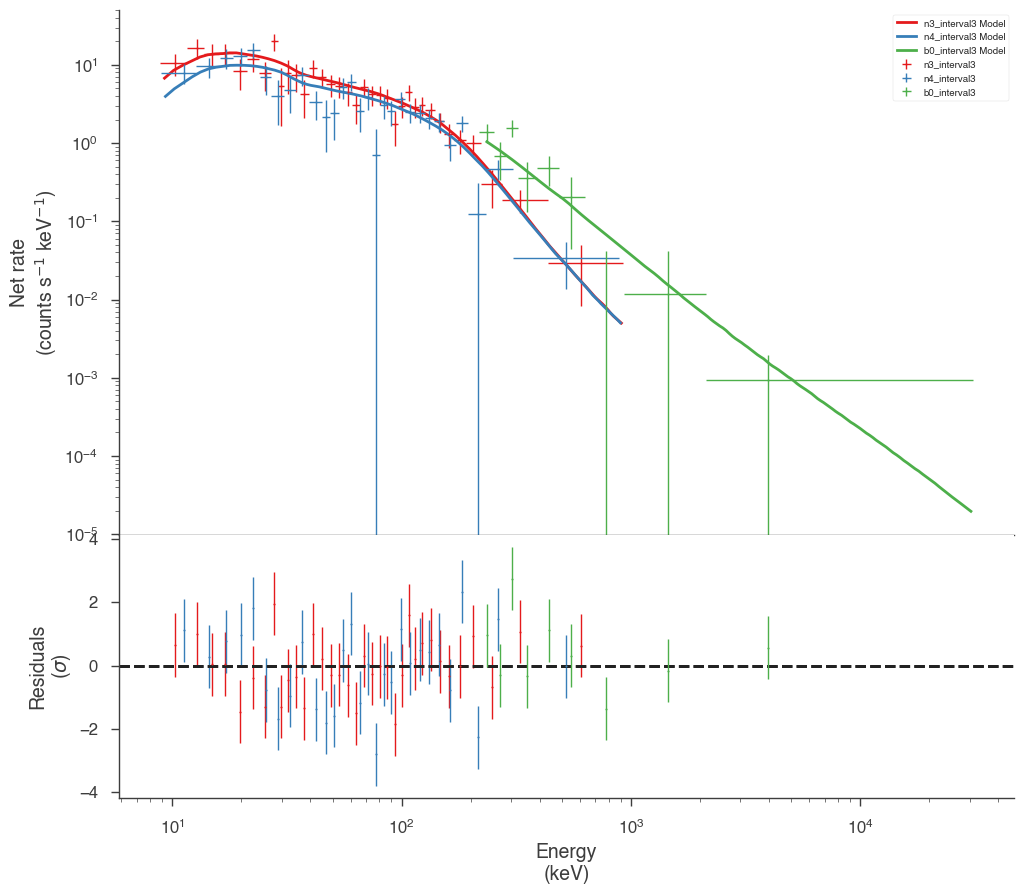

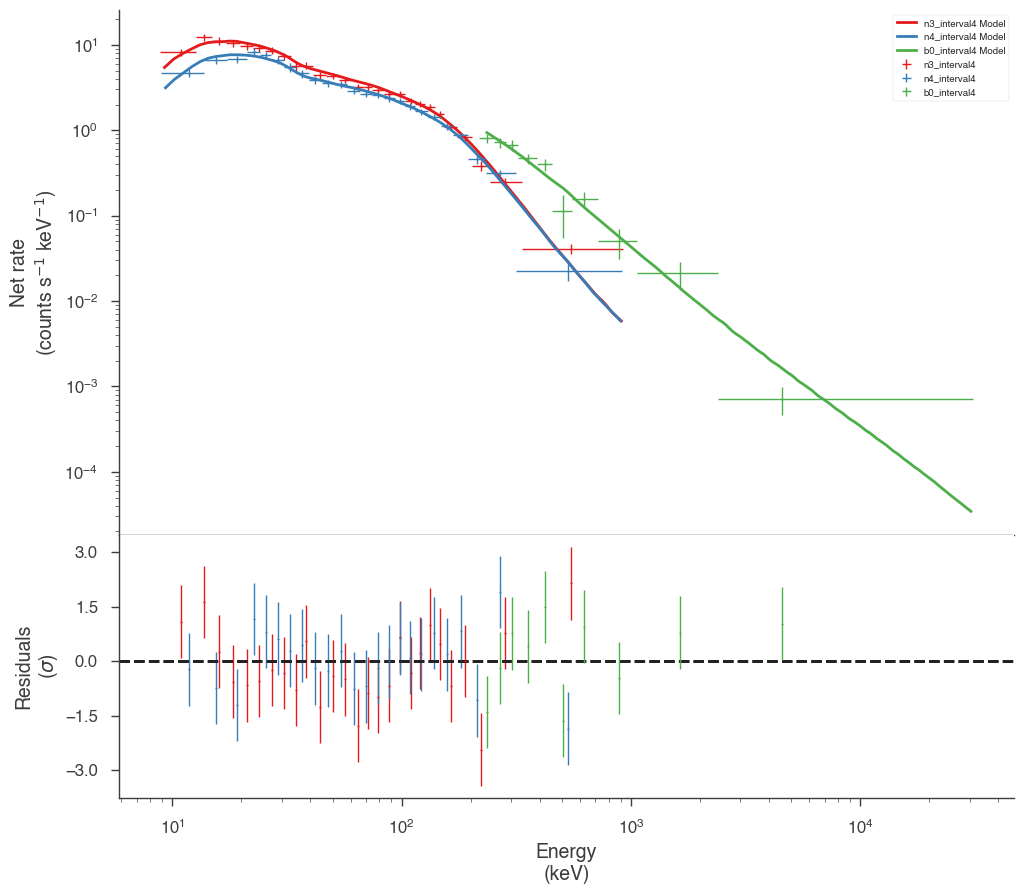

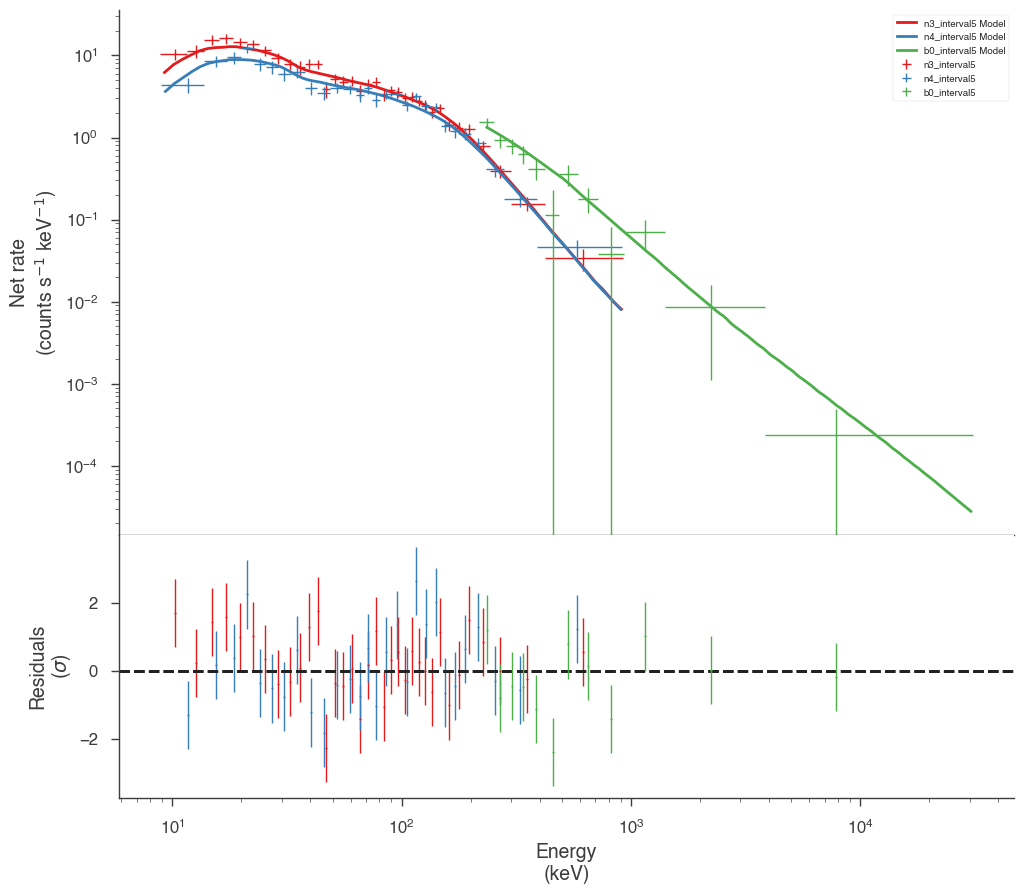

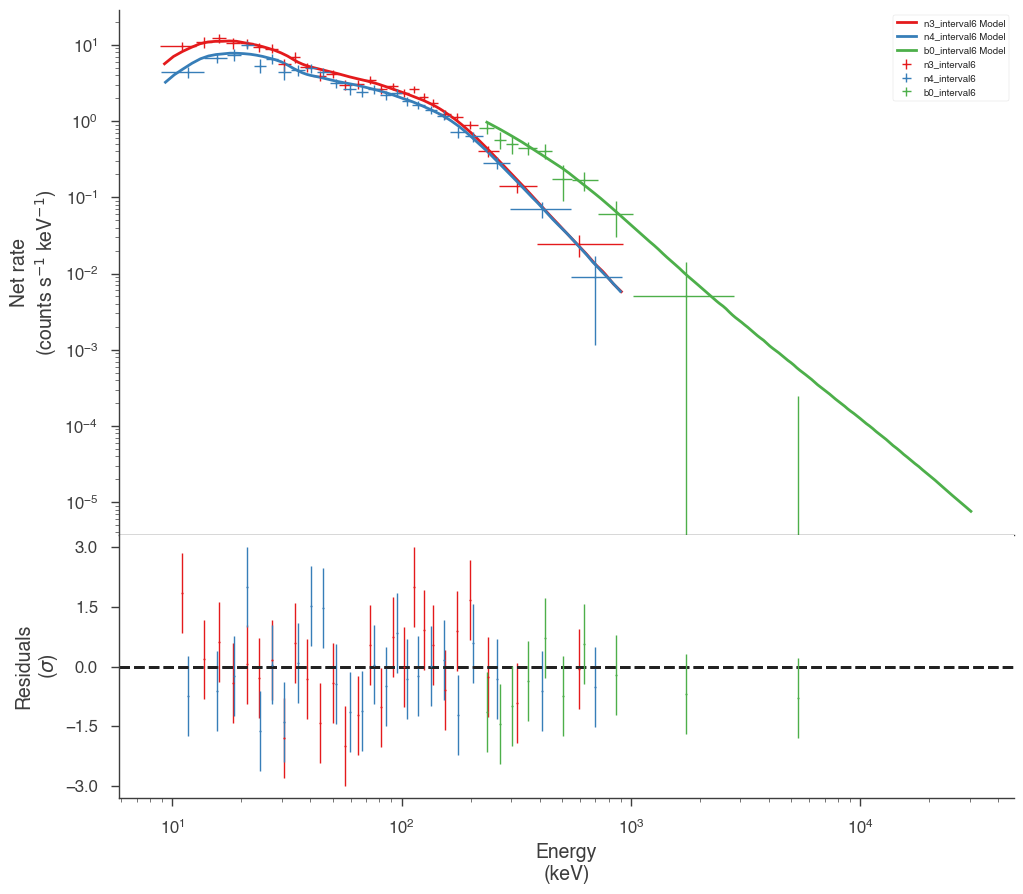

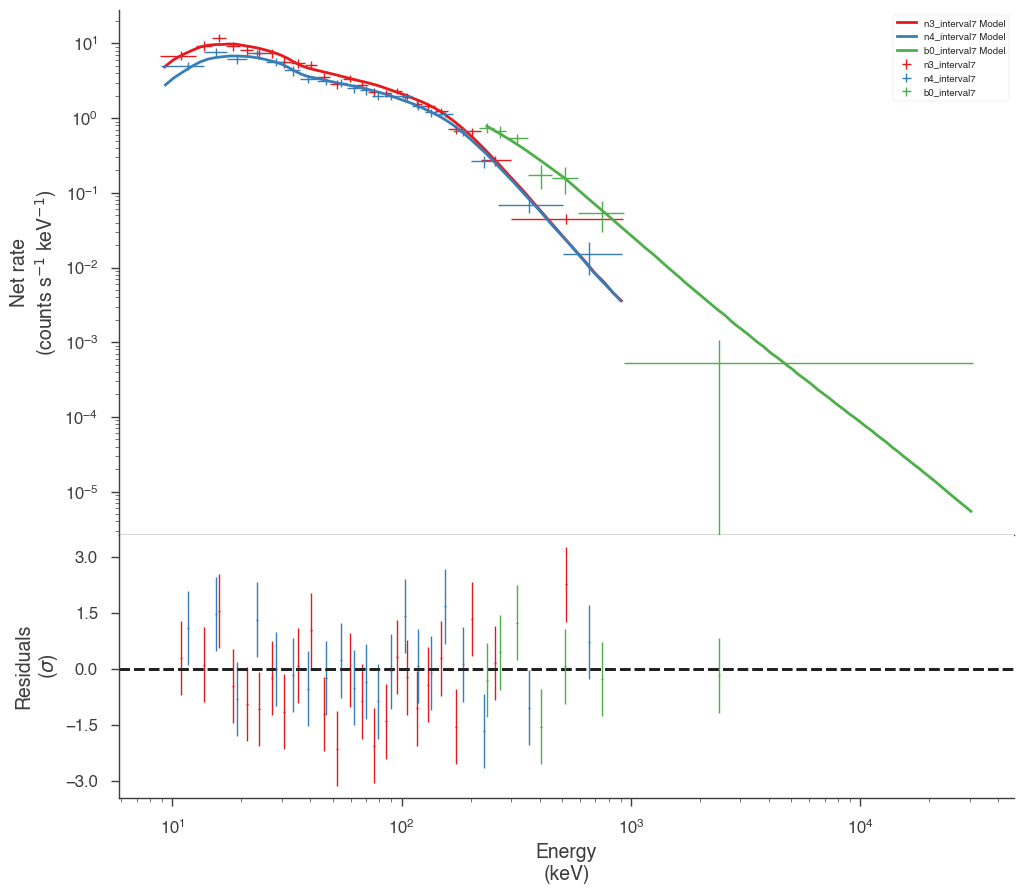

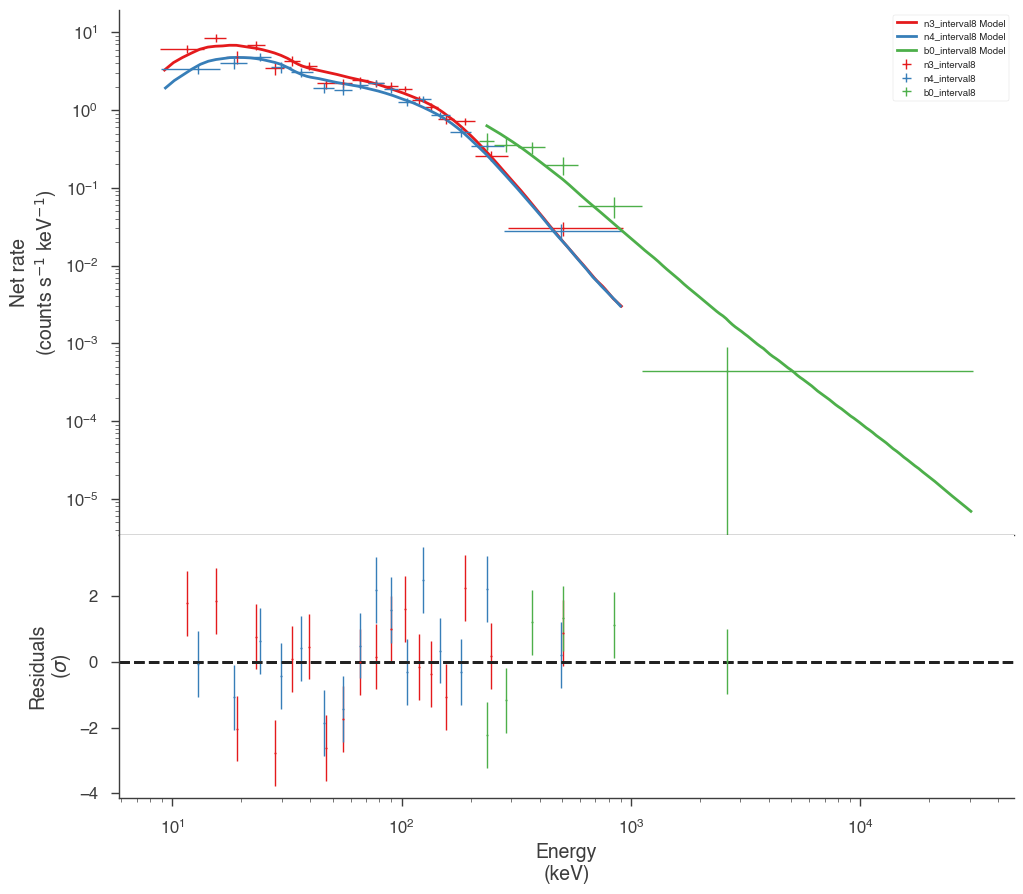

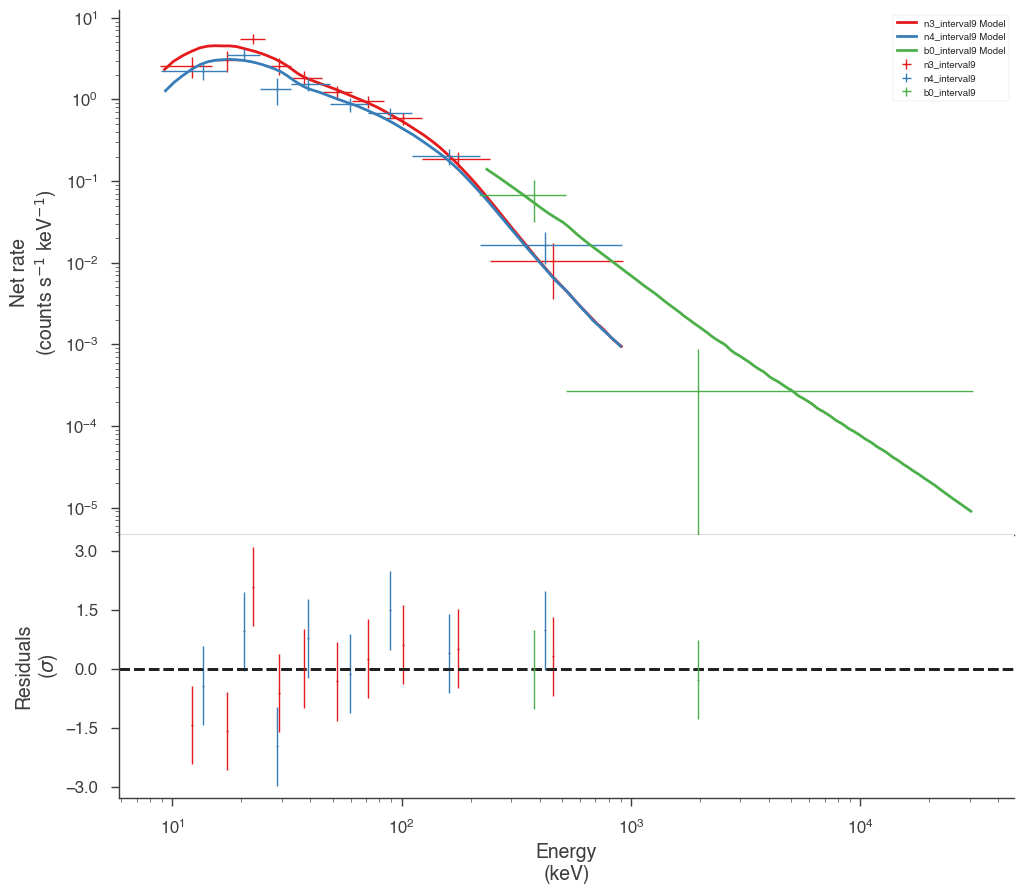

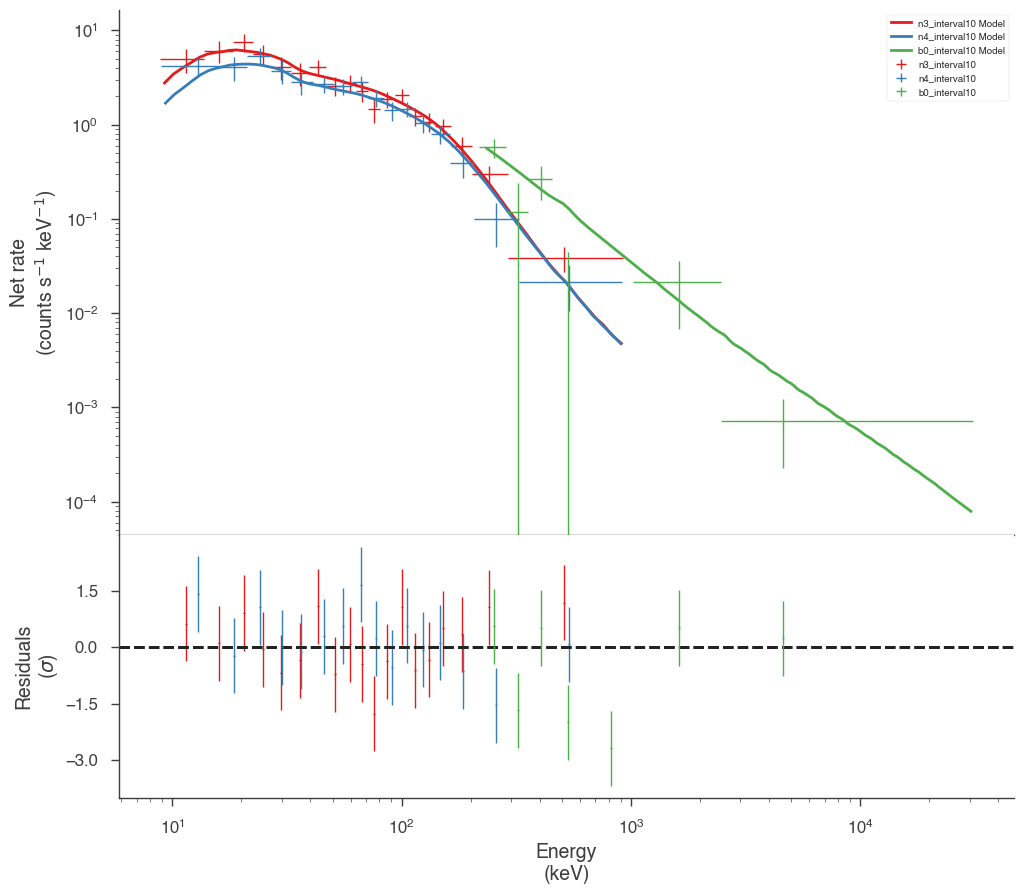

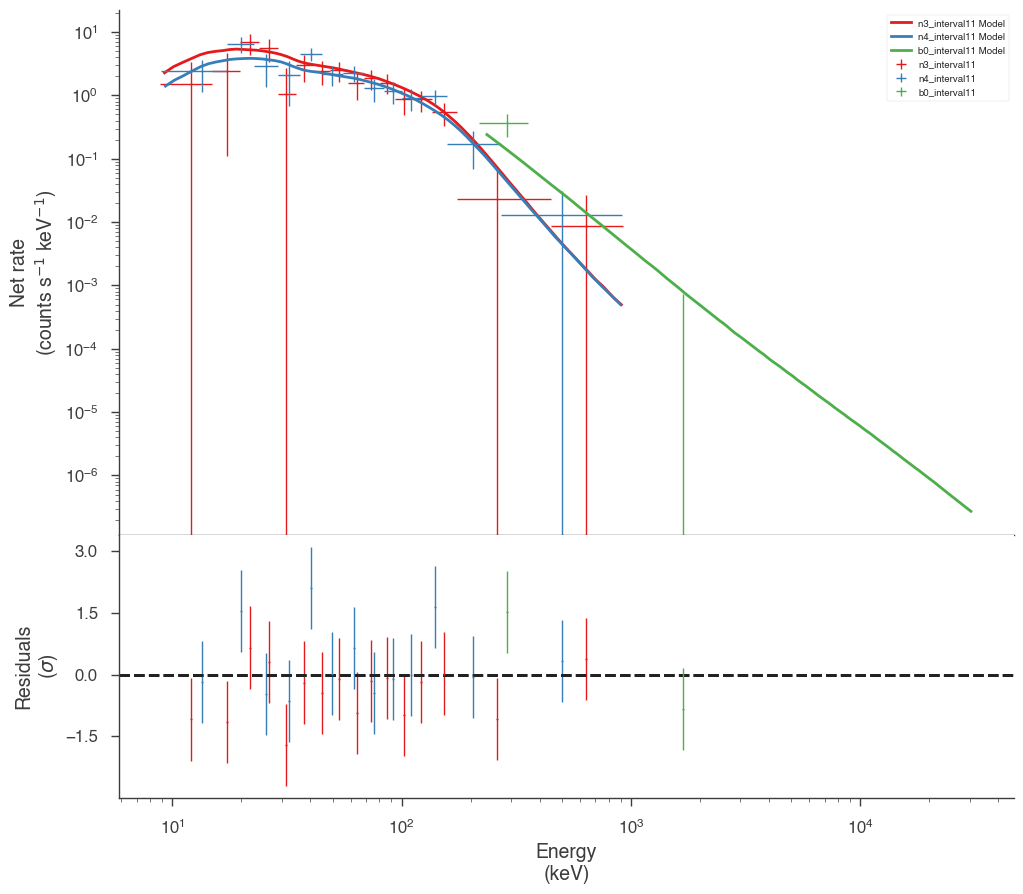

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

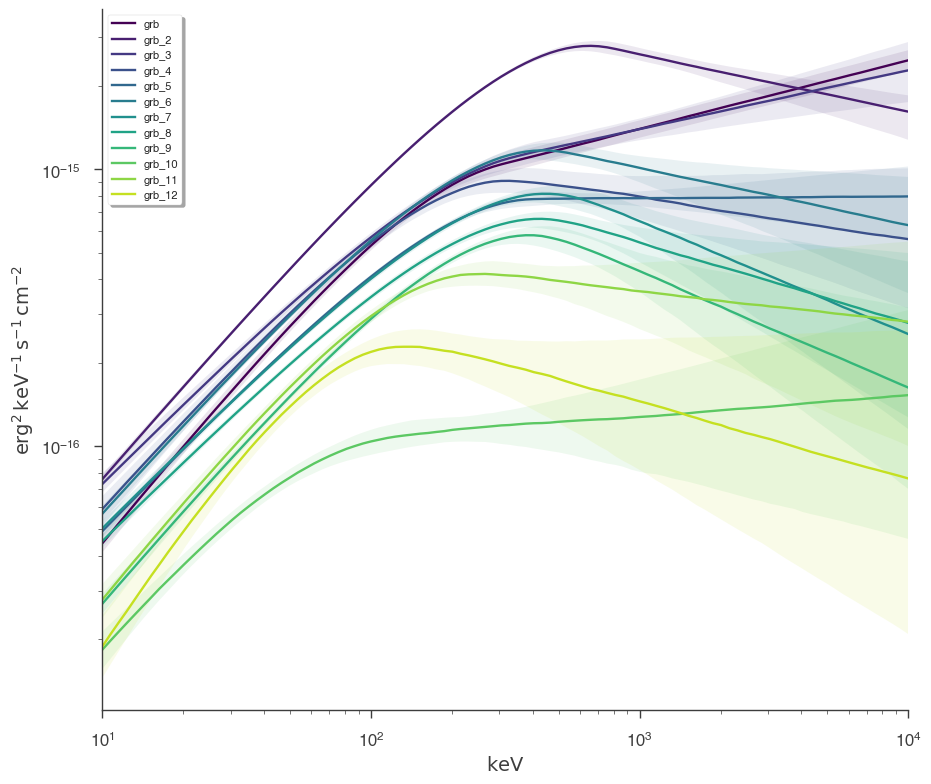

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.